# Лабораторная работа по дисциплине "Дополнительные главы методов оптимизации" 

### Цель
Программно реализовать алгоритмы нахождения 1 и 2 мостов в неориентированном графе в детерминированном и рандомизированном вариантах. Сравнить время выполнения реализаций в зависимости от размера задачи(количество вершин/ребер) 

### Задачи:
- ознакомиться с библиотекой **networkx**
- реализовать алгоритмы поразрядной и карманной сортировок
- реализовать алгоритмы нахождения 1 и 2 мостов в неориентированных графах
    - нахождение 1-моста с детерминированным подходом
    - нахождение 1-моста и 2-мостов с рандомизированным подходом
- провести unit-test для каждой реализации алгоритмов
- провести stress-test для каждой реализации нахождения мостов
- сделать замеры времени выполнения алгоритмов в зависимости от размера задачи и различных плотностей графов

### Выполнили: Назиров М., Лепигина А. МАГ ИАД 18
### Проверил: Грибанов Д. В.

In [1]:
import networkx as nx
import numpy as np
from math import log2, floor, ceil
from enum import Enum

In [2]:
# вспомогательный класс структуры данных Стек для реализации обхода в глубину графов без использования рекурсии
class Stack :
    def __init__(self):
        self.items = []

    def push(self, item):
        self.items.append(item)

    def pop(self):
        return self.items.pop()
    
    def last(self): 
        return self.items[-1]

    def is_empty(self):
        return (self.items == [])

### Реализации алгоритмов 

In [3]:
# реализация детерминированного алгоритма нахождения 1-моста
class BridgeDetermined:
    def __init__(self, graph: nx.Graph):
        self.graph = graph
        self.bridges = []
        self.used = np.zeros(graph.number_of_nodes())
        self.enter = np.zeros(graph.number_of_nodes())
        self.ret = np.zeros(graph.number_of_nodes()) 
        self.time = 0
        self.stack = Stack()
        
    def on_bridge_found(self, edge):
        self.bridges.append(edge)
    
    def dfs(self, v):
        root = -1;
        self.stack.push((v, root, 0, 0))
        new_invoke = True
        while (not self.stack.is_empty()):            
            if new_invoke:
                v, p, _, _ = self.stack.last()
                self.time += 1
                self.used[v] = 1
                self.enter[v] = self.ret[v] = self.time
                new_invoke = False    
                for i in range(len(self.graph[v])):
                    u = list(self.graph[v])[i]
                    if u == p:
                        continue
                    if self.used[u]:
                        self.ret[v] = min(self.ret[v], self.enter[u])
                    else:
                        self.stack.push((u, v, i, p))
                        new_invoke = True
                        break
            else:
                u, v, ni, p = self.stack.pop() #restore state of cycle in stack
                if (v == root):
                     continue
                self.ret[v] = min(self.ret[v], self.ret[u]) 
                if self.ret[u] > self.enter[v]:
                    self.on_bridge_found((u, v))   
                for i in range(ni + 1, len(self.graph[v])):
                    u = list(self.graph[v])[i]
                    if u == p:
                        continue
                    if self.used[u]:
                        self.ret[v] = min(self.ret[v], self.enter[u])
                    else:
                        self.stack.push((u, v, i, p))
                        new_invoke = True
                        break
             
    def find_bridges(self):
        for i in range(self.graph.number_of_nodes()):
            if not self.used[i]:
                self.dfs(i)

In [4]:
# реализация рандомизированного алгоритма нахождения 1 и 2 мостов
NUM_MAX_RAND = 2 ** 64

class BridgeRandomizedBase:
    def __init__(self, graph: nx.Graph):
        self.graph = graph
        self.used = np.zeros(graph.number_of_nodes())
        self.stack = Stack()
        for (_, _, w) in self.graph.edges(data=True):
            w['weight'] = -1
    
    @staticmethod
    def next_randint():
        return np.random.randint(0, NUM_MAX_RAND, size=1, dtype='uint64')[0]
    
    def dfs(self, v):
        root = -1
        new_invoke = True
        self.stack.push((v, root, 0, 0))    
        while not self.stack.is_empty():
            if new_invoke == True:
                v, p, _, _ = self.stack.last()
                self.used[v] = 1
                new_invoke = False
                for i in range(len(self.graph[v])):
                    u = list(self.graph[v])[i]
                    if u == p:
                        continue
                    if not self.used[u]:
                        self.stack.push((u, v, p, i))
                        new_invoke = True
                        break
                    elif self.graph[v][u]['weight'] == -1:
                        self.graph[v][u]['weight'] = self.next_randint()
            else:
                _, v, p, ni = self.stack.pop()

                for i in range(ni + 1, len(self.graph[v])):
                    u = list(self.graph[v])[i]
                    if u == p:
                        continue
                    if not self.used[u]:
                        self.stack.push((u, v, p, i))
                        new_invoke = True
                        break
                    elif self.graph[v][u]['weight'] == -1:
                        self.graph[v][u]['weight'] = self.next_randint()
            
            if new_invoke:
                continue
            if p == root: #p-root
                return
            res = 0
            for u in self.graph[v]:
                if u == p:
                    continue
                w = int(self.graph[v][u]['weight'])
                res ^= w
            self.graph[v][p]['weight'] = res

            
class Bridge1Randomized(BridgeRandomizedBase):
    def __init__(self, graph: nx.Graph):
        BridgeRandomizedBase.__init__(self, graph)
        self.bridges = []
        
    def find_bridges(self):
        for i in range(self.graph.number_of_nodes()):
            if not self.used[i]:
                self.dfs(i)

        for (u, v, w) in self.graph.edges(data=True):
            if w['weight'] == 0:
                self.bridges.append((u, v))
                
            
class SortMeth(Enum):
        RADIX = 0,
        TRIMSORT = 1,
        BUCKET = 2


class Bridge2Randomized(BridgeRandomizedBase):
    def __init__(self, graph: nx.Graph):
        BridgeRandomizedBase.__init__(self, graph)
        self.sorted_edges = []

        
    @staticmethod
    def bucked_sort(arraylist: list) -> list:
        import operator
        from functools import reduce

        n = len(arraylist)
        B = [list() for _ in range(n)]

        for item in arraylist:
            index = floor(n * item[2]['weight']/float(NUM_MAX_RAND))
            B[index].append(item)
        
        res = []
        for deq in B:
            res.append(sorted(deq, key=lambda t: t[2]['weight']))
        
        total = []
        for r in res:
            for el in r:
                total.append(el)
        return total


    @staticmethod
    def radix_sort(array: list) -> list:
        array = list(filter(lambda x: len(x) != 0, array))
        B = [0] * len(array)
        
        SS = 2**16 - 1

        for i in range(0, ceil(log2(NUM_MAX_RAND)/4)):
            # для каждого разряда используется сортировка подсчетом         
            counters = [0] * (SS+1)

            for item in array:
                w = int(item[2]['weight'])
                num = (w >> i*16) & SS
                counters[num] += 1   
            
            for j in range(1, SS+1):
                counters[j] += counters[j-1]

            for item in array[::-1]:
                w = int(item[2]['weight'])
                num = (w >> i*16) & SS

                B[counters[num]-1] = item
                counters[num] -= 1
                
            array = B
        return array

    
    def run(self, sort: SortMeth):
        for i in range(self.graph.number_of_nodes()):
            if not self.used[i]:
                self.dfs(i)

        if sort == SortMeth.RADIX:
            self.sorted_edges = self.radix_sort(self.graph.edges(data=True))
        elif sort == SortMeth.TRIMSORT:
            self.sorted_edges = sorted(self.graph.edges(data=True), key=lambda t: t[2]['weight'])
        else:
            self.sorted_edges = self.bucked_sort(self.graph.edges(data=True))

### Юнит-тесты и стресс-тесты реализованных алгоритмов

In [5]:
import unittest
from math import log

class TestNotebook(unittest.TestCase):
    
    def test_radix_sort(self):
        g = nx.generators.erdos_renyi_graph(1000, 0.01)
        for (_, _, w) in g.edges(data=True):
            w['weight'] = BridgeRandomizedBase.next_randint()
        sorted_edges = Bridge2Randomized.radix_sort(g.edges(data=True))
        wi = sorted_edges[0][2]['weight']
        for (_, _, w) in sorted_edges:
            if wi > w['weight']:
                self.fail("radix is not correct")
            wi = w['weight']
        
    def test_bucket_sort(self):
        g = nx.generators.erdos_renyi_graph(1000, 0.01)
        for (_, _, w) in g.edges(data=True):
            w['weight'] = BridgeRandomizedBase.next_randint()
        sorted_edges = Bridge2Randomized.bucked_sort(g.edges(data=True))
        wi = sorted_edges[0][2]['weight']
        for (_, _, w) in sorted_edges:
            if wi > w['weight']:
                self.fail("bucket is not correct")
            wi = w['weight']
            
    def test_stress_determined(self):
        for _ in range(100):
            g = nx.generators.erdos_renyi_graph(1000, 0.005) 
            brDet = BridgeDetermined(g)
            brDet.find_bridges()
            if len(brDet.bridges) != len(list(nx.bridges(g))):
                self.fail("Deterministic alg is not correct")
            
    def test_stress_radom_bridge1(self):
        for _ in range(100):
            g = nx.generators.erdos_renyi_graph(1000, 0.005) 
            brRand = Bridge1Randomized(g)
            brRand.find_bridges()
            if len(brRand.bridges) != len(list(nx.bridges(g))):
                self.fail("Randomized alg bridge1 is not correct")                      
    
    def filter_edges_to_bridges(self, sorted_edges) -> list:
        graph = nx.from_edgelist(sorted_edges)
        bridges = []
        n_comp = nx.number_connected_components(graph)
        while True:
            potential_bridge =  sorted_edges.pop(0)
            graph.remove_edge(*potential_bridge[:2])
            n_next = int(nx.number_connected_components(graph))
            graph.add_edge(*potential_bridge[:2])
            if n_next == n_comp or len(sorted_edges) == 0:
                break
            bridges.append(potential_bridge[:2])
        del graph
        return bridges
    
    def test_stress_radom_bridge2(self):
        countFail = 0
        for _ in range(100):
            g = nx.generators.erdos_renyi_graph(1000, 0.005) 
            brRand = Bridge2Randomized(g)
            brRand.run(SortMeth.BUCKET)
            bridges = self.filter_edges_to_bridges(brRand.sorted_edges)
            if len(bridges) != len(list(nx.bridges(g))):
                countFail += 1
                if countFail > 1:
                    self.fail("Randomized alg bridge2 is not correct") 
            
unittest.main(argv=[''], verbosity=2, exit=False)

test_bucket_sort (__main__.TestNotebook) ... ok
test_radix_sort (__main__.TestNotebook) ... ok
test_stress_determined (__main__.TestNotebook) ... ok
test_stress_radom_bridge1 (__main__.TestNotebook) ... ok
test_stress_radom_bridge2 (__main__.TestNotebook) ... ok

----------------------------------------------------------------------
Ran 5 tests in 34.243s

OK


### Замеры времени выполнения реализаций алгоритмов при разном количестве вершин/ребёр в графе и его различной плотности

In [5]:
# вспомогательные функции для сохранения/загрузки полученных данных
def save_stat(name, dictSt):
    import pickle
    import os
    if not os.path.exists('data'):
        os.makedirs('data')
    f = open("./data/" + name + ".pkl", "wb")
    pickle.dump(dictSt, f)
    f.close()
def load_stat(name):
    import pickle
    f = open("./data/" + name + ".pkl", "rb")
    return pickle.load(f)

In [6]:
det = 'determ'
rand1 = 'rand1'
rand2trim = 'rand2trim'
rand2bucket = 'rand2bucket'
rand2radix = 'rand2radix'

In [ ]:
from time import clock
from math import sqrt
from copy import deepcopy

basedict = {det: [], rand1: [], rand2trim: [], rand2bucket: [], rand2radix: []}

sparse = deepcopy(basedict)
dense = deepcopy(basedict)
semidense = deepcopy(basedict)

def run_det(g):
    start = clock()
    brDet = BridgeDetermined(g)
    brDet.find_bridges()
    return clock() - start

def run_rand1(g):
    start = clock()
    brRand = Bridge1Randomized(g)
    brRand.find_bridges()
    return clock() - start

def run_rand2(g, sortMeth):
    start = clock()
    brRand = Bridge2Randomized(g)
    brRand.run(sortMeth)
    return clock() - start

def evalGraph(dictSt, n, m):
    g = nx.generators.gnm_random_graph(n, m)
    
    t = run_det(g)
    dictSt[det].append((n, m, t))
    t = run_rand1(g)
    dictSt[rand1].append((n, m, t))
    t = run_rand2(g, SortMeth.TRIMSORT)
    dictSt[rand2trim].append((n, m, t))
    t = run_rand2(g, SortMeth.BUCKET)
    dictSt[rand2bucket].append((n, m, t))
    t = run_rand2(g, SortMeth.RADIX)
    dictSt[rand2radix].append((n, m, t))

DN = 2000

# для разреженнего графа m = c*n, c=4
print('__________SPARSE___________')
sc = 4
for (n, m) in [(n, sc*n) for n in range(DN, 50000 + DN, DN)]:
    print("n=", n, " m=", m)
    evalGraph(sparse, n, m)
    save_stat("sparse", sparse)
    
# для "полуплотного" графа m = n^(3/2)с, c=10000
print('__________SEMIDENSE___________')
sdc = 10000
for (n, m) in [(n, ceil(n*n/(sdc+ceil(sqrt(n))))) for n in range(DN, 100000 + DN, DN)]:
    print("n=", n, " m=", m)
    evalGraph(semidense, n, m)
    save_stat("semidense", semidense)
    
# для плотного графа m = n^(2)/с, c=1000
print('__________DENSE___________')
dc = 1000
for (n, m) in [(n, floor(n*n/dc)) for n in range(DN, 100000 + DN, DN)]:
    print("n=", n, " m=", m)
    evalGraph(dense, n, m)
    save_stat("dense", dense)

### Визуализация полученных результатов

In [7]:
import matplotlib.pyplot as plt

def get_xn_data(dictSt, mode):
    return [n for (n, _, _) in dictSt[mode]]


def get_xm_data(dictSt, mode):
    return [m for (_, m, _) in dictSt[mode]]


def get_y_data(dictSt, mode):
    return [t for (_, _, t) in dictSt[mode]]

def plot_data(dictSt, title):
    fig, ax1 = plt.subplots(figsize=(12, 7))
    ax1.set_title(title)
    ax1.set_ylabel('Время выполнения в секундах')
    ax1.set_xlabel('Количество рёбер')
    
    ax1.plot(get_xm_data(dictSt, det), get_y_data(dictSt, det), label='Determined')
    ax1.plot(get_xm_data(dictSt, rand1), get_y_data(dictSt, rand1), label='Randomized1')
    ax1.plot(get_xm_data(dictSt, rand2trim), get_y_data(dictSt, rand2trim), label='Rand2trim')
    ax1.plot(get_xm_data(dictSt, rand2bucket), get_y_data(dictSt, rand2bucket), label='Rand2bucket')
    ax1.plot(get_xm_data(dictSt, rand2radix), get_y_data(dictSt, rand2radix), label='Rand2radix')
    ax1.legend(loc = 'best')
    
    ax2 = ax1.twiny()
    ax2.set_xlabel('Количество вершин')
    ax2.plot(get_xn_data(dictSt, det), get_y_data(dictSt, det), color=(0.1, 0.2, 0.5, 0))
    
    fig.tight_layout()
    plt.show()

In [8]:
sparse = load_stat("sparse")
semidense = load_stat("semidense")
dense = load_stat("dense")

for mode in dense:
    d = dense[mode]
    dense[mode] = d[:30]

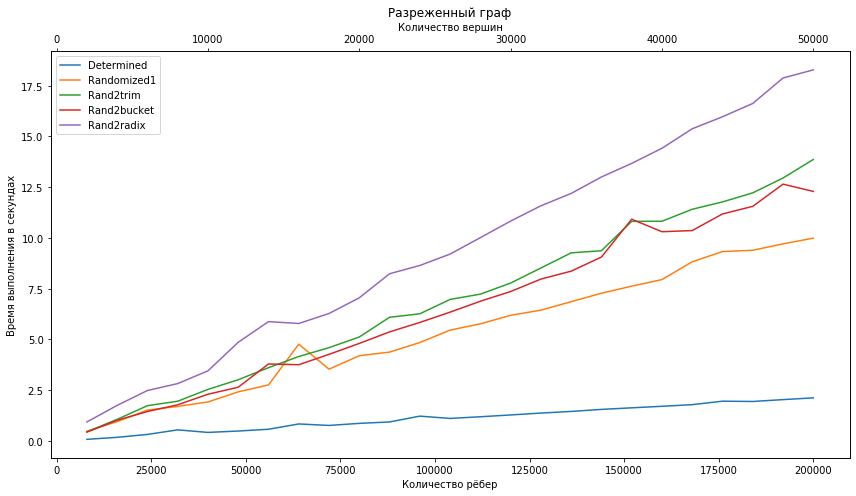

In [9]:
plot_data(sparse, "Разреженный граф")

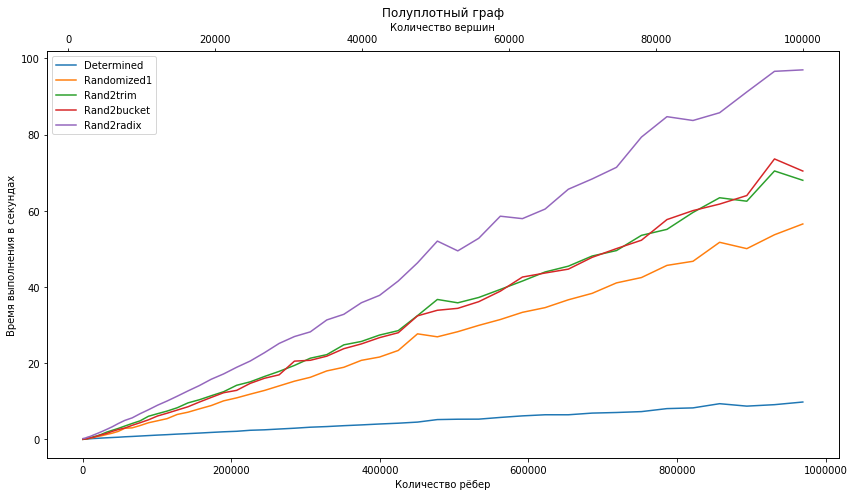

In [10]:
plot_data(semidense, "Полуплотный граф")

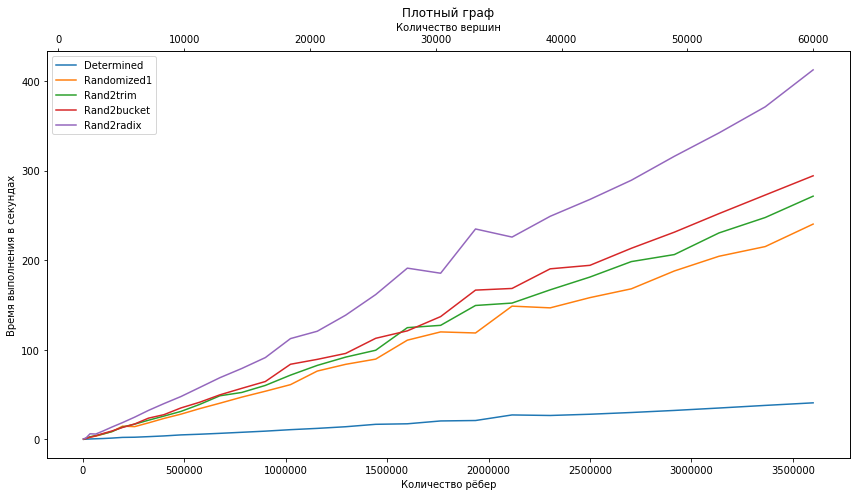

In [11]:
plot_data(dense, "Плотный граф")

### Вывод

Все поставленные задачи были выполнены, полученные результаты визуализированы. По всем графикам видна линейная зависимость роста времени выполнения задачи от ее размера, что и ожидалось в начале. 
Из всех представленных сортировок, наименее быстрой оказалась radix-sort, тогда как bucket-sort в разреженных графах показала наилучший результат среди остальных, а в плотных графах быстрее всех оказалась trim-sort.